# Ivan Alexander Ramos Ramirez A01750817
# Módulo 2  Análisis y Reporte sobre 
#  el desempeño del modelo. (Portafolio Implementación)

In [1]:
from Neural import NeuralNet
from Neural import stratified_split
#cross validation
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

In [15]:
from sklearn.datasets import load_digits

In [16]:
digits = load_digits()
X, y = digits.data, digits.target

print("Shape de X:", X.shape)   # (1797, 64)
print("Shape de y:", y.shape)   # (1797,)
print("Clases:", set(y))        # {0,1,2,...,9}
print("Número de muestras:", len(y))
print("Número de features:", X.shape[1])
print("Dimensión de cada imagen:", digits.images[0].shape)

Shape de X: (1797, 64)
Shape de y: (1797,)
Clases: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}
Número de muestras: 1797
Número de features: 64
Dimensión de cada imagen: (8, 8)


In [4]:
# Congelar copias crudas para evitar contaminación por ejecuciones previas
X_raw = X.astype(np.float64).copy()
y_raw = y.copy()

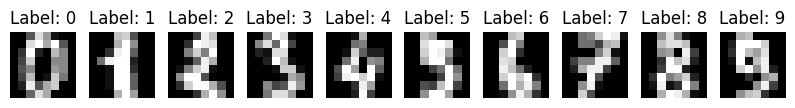

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(10,3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.show()


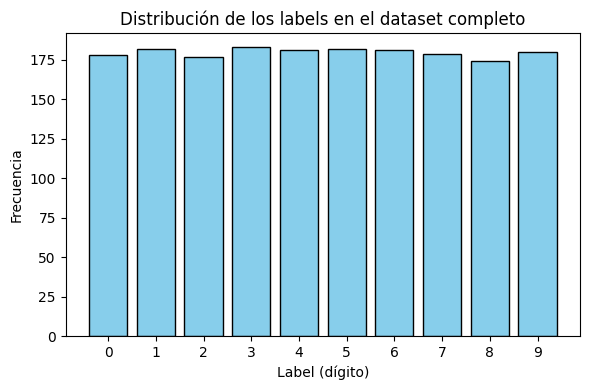

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizar la distribución de los labels del target en el dataset completo
labels, counts = np.unique(y_raw, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color='skyblue', edgecolor='k')
plt.xlabel('Label (dígito)')
plt.ylabel('Frecuencia')
plt.title('Distribución de los labels en el dataset completo')
plt.xticks(labels)
plt.tight_layout()
plt.show()

In [25]:
labels, counts = np.unique(y_raw, return_counts=True)
percentages = 100 * counts / counts.sum()

for label, pct in zip(labels, percentages):
    print(f"Label {label}: {pct:.2f}%")

Label 0: 9.91%
Label 1: 10.13%
Label 2: 9.85%
Label 3: 10.18%
Label 4: 10.07%
Label 5: 10.13%
Label 6: 10.07%
Label 7: 9.96%
Label 8: 9.68%
Label 9: 10.02%


In [6]:
# Diagnóstico de varianza y NaNs antes del escalado (usar X_raw)
stds_raw = X_raw.std(axis=0)
zero_var_count = np.sum((stds_raw == 0) | ~np.isfinite(stds_raw))
print("Features con varianza cero o std no finita:", int(zero_var_count))
print("Alguna NaN en X_raw?", np.isnan(X_raw).any())

Features con varianza cero o std no finita: 3
Alguna NaN en X_raw? False


In [7]:
# Comprobaciones sobre datos crudos (definir X_before_scaling)
X_before_scaling = X_raw
assert np.issubdtype(X_before_scaling.dtype, np.number), "Non-numeric dtype detected"

# Pre-existing non-finites, esto sirve para identificar NaNs o infs en los datos
print("Raw non-finites:", (~np.isfinite(X_before_scaling)).sum())

# Zero-variance columns (σ = 0), esto sirve para identificar columnas que no aportan información
std0_cols = np.where(np.nanstd(X_before_scaling, axis=0) == 0)[0]
print("Zero-variance cols:", std0_cols)

Raw non-finites: 0
Zero-variance cols: [ 0 32 39]


In [8]:
# Configurar y entrenar la red
modelo1 = NeuralNet(
    learning_rate=0.01,
    activation_function='ReLu',
    layer_neurons=[32, 16],  # un poco más de capacidad que [6,4]
    epoch=200,
    batch_size=32
)

# Usar copias crudas para evitar contaminación
X_use = X_raw
y_use = y_raw

# Asegurar y 1D
if y_use.ndim > 1:
    y_use = y_use.ravel()

X_raw shape: (1797, 64)
Rango (raw): 0.0 → 16.0


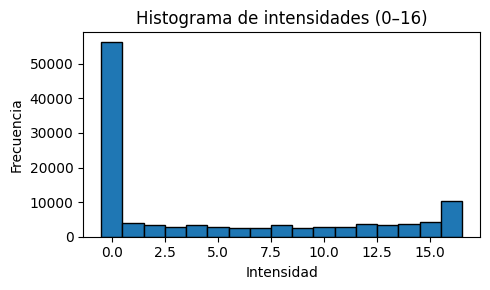

In [18]:
import numpy as np
import matplotlib.pyplot as plt

print("X_raw shape:", X_raw.shape)  # (1797, 64)
print("Rango (raw):", X_raw.min(), "→", X_raw.max())

plt.figure(figsize=(5,3))
plt.hist(X_raw.ravel(), bins=np.arange(-0.5, 17.5, 1), edgecolor='k')
plt.title("Histograma de intensidades (0–16)")
plt.xlabel("Intensidad"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

In [9]:
X_train, X_test, X_val, y_train, y_test, y_val = stratified_split(X_use, y_use, test_size=0.15, validation_size=0.15)

In [10]:

# Guardar copias sin escalar para CV y escalado reproducible
X_train_raw = X_train.copy()
X_val_raw = X_val.copy()
X_test_raw = X_test.copy()

# Estadísticos del train usando SOLO train_raw
mean_train = X_train_raw.mean(axis=0)
std_train = X_train_raw.std(axis=0)

# Evitar std = 0 o NaN
std_train = np.nan_to_num(std_train, nan=0.0)
std_train[std_train == 0] = 1.0

# Escalado para el entrenamiento base y test (no contamina CV)
X_train = (X_train_raw - mean_train) / std_train
X_test = (X_test_raw - mean_train) / std_train


In [11]:

# Split primero, luego escalar con estadísticos del train
# mostrando la separacion de los datos
print("original Shape:", X_use.shape, y_use.shape)
print("Train shape:", X_train.shape, y_train.shape, f"{100 * len(y_train) / len(y_use):.1f}%")
print("Test shape:", X_test.shape, y_test.shape, f"{100 * len(y_test) / len(y_use):.1f}%")
print("Validation shape:", X_val.shape, y_val.shape, f"{100 * len(y_val) / len(y_use):.1f}%")


original Shape: (1797, 64) (1797,)
Train shape: (1265, 64) (1265,) 70.4%
Test shape: (266, 64) (266,) 14.8%
Validation shape: (266, 64) (266,) 14.8%


In [ ]:



# Chequeos rápidos de sanidad, esto ayuda a detectar problemas antes de entrenar
assert np.isfinite(X_train).all() and np.isfinite(X_test).all(), "Hay NaN/Inf tras el escalado"


In [13]:

# Entrenamiento
modelo1.fit(X_train, y_train)

# Predicción y métricas
y_pred = modelo1.predict(X_test)
class_to_idx = {c: i for i, c in enumerate(modelo1.classes)}
y_test_idx = np.array([class_to_idx[label] for label in y_test])

test_acc = np.mean(y_pred == y_test_idx)
print(f"Accuracy test: {test_acc:.3f}")

# Pérdida de test
y_pred_test, _, _ = modelo1._forward(X_test)
print(f"Loss test: {modelo1._CategoricalCrossEntropy(y_test_idx, y_pred_test):.3f}")

Epoch   1 | loss=2.4537 | acc=0.191
Epoch  10 | loss=0.9577 | acc=0.763
Epoch  10 | loss=0.9577 | acc=0.763
Epoch  20 | loss=0.3725 | acc=0.913
Epoch  20 | loss=0.3725 | acc=0.913
Epoch  30 | loss=0.2055 | acc=0.949
Epoch  30 | loss=0.2055 | acc=0.949
Epoch  40 | loss=0.1387 | acc=0.971
Epoch  40 | loss=0.1387 | acc=0.971
Epoch  50 | loss=0.1027 | acc=0.982
Epoch  50 | loss=0.1027 | acc=0.982
Epoch  60 | loss=0.0770 | acc=0.989
Epoch  60 | loss=0.0770 | acc=0.989
Epoch  70 | loss=0.0610 | acc=0.993
Epoch  70 | loss=0.0610 | acc=0.993
Epoch  80 | loss=0.0498 | acc=0.994
Epoch  80 | loss=0.0498 | acc=0.994
Epoch  90 | loss=0.0414 | acc=0.996
Epoch  90 | loss=0.0414 | acc=0.996
Epoch 100 | loss=0.0352 | acc=0.998
Epoch 100 | loss=0.0352 | acc=0.998
Epoch 110 | loss=0.0304 | acc=0.998
Epoch 110 | loss=0.0304 | acc=0.998
Epoch 120 | loss=0.0266 | acc=0.998
Epoch 120 | loss=0.0266 | acc=0.998
Epoch 130 | loss=0.0231 | acc=0.999
Epoch 130 | loss=0.0231 | acc=0.999
Epoch 140 | loss=0.0208 | ac

In [22]:
#evaluacion inicial del modelo con metricas
from sklearn.metrics import classification_report, accuracy_score

# y_pred_te ya contiene las predicciones del test
# y_test_idx son los índices verdaderos

print("Accuracy:", accuracy_score(y_test_idx, y_pred_te))
print("Reporte de clasificación:")
print(classification_report(y_test_idx, y_pred_te, digits=3))

Accuracy: 0.9774436090225563
Reporte de clasificación:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        26
           1      0.962     0.926     0.943        27
           2      1.000     1.000     1.000        26
           3      0.964     1.000     0.982        27
           4      0.931     1.000     0.964        27
           5      0.963     0.963     0.963        27
           6      1.000     0.963     0.981        27
           7      1.000     0.962     0.980        26
           8      1.000     0.962     0.980        26
           9      0.964     1.000     0.982        27

    accuracy                          0.977       266
   macro avg      0.978     0.977     0.978       266
weighted avg      0.978     0.977     0.977       266



Train acc=0.999 loss=0.011
Val   acc=0.951 loss=0.279  (gap=0.048)
Test  acc=0.977 loss=0.146 (gap=0.022)
Diagnóstico de bias: bajo
Indicadores: alta precisión en train. Si el gap es grande, el problema es varianza (overfitting).


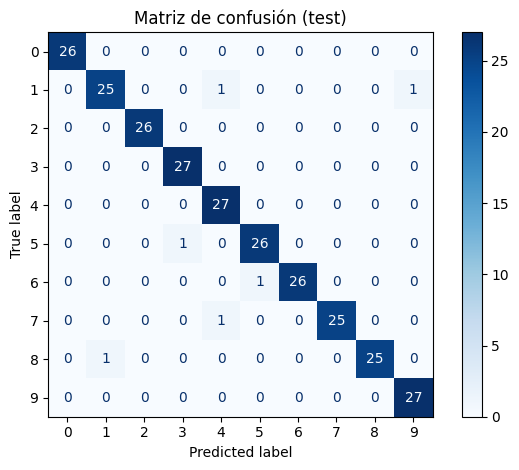

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Escalar validación con las estadísticas del train (si no lo hiciste antes)
X_val_s = (X_val_raw - mean_train) / std_train

# Predicciones
y_pred_tr = modelo1.predict(X_train)
y_pred_va = modelo1.predict(X_val_s)
y_pred_te = modelo1.predict(X_test)

# Mapear labels → índices según el modelo
class_to_idx = {c: i for i, c in enumerate(modelo1.classes)}
y_train_idx = np.array([class_to_idx[l] for l in y_train])
y_val_idx   = np.array([class_to_idx[l] for l in y_val])
y_test_idx  = np.array([class_to_idx[l] for l in y_test])

# Accuracies
train_acc = (y_pred_tr == y_train_idx).mean()
val_acc   = (y_pred_va == y_val_idx).mean()
test_acc  = (y_pred_te == y_test_idx).mean()

# Losses (usa el forward y la CCE del modelo)
p_tr, _, _ = modelo1._forward(X_train)
p_va, _, _ = modelo1._forward(X_val_s)
p_te, _, _ = modelo1._forward(X_test)
train_loss = modelo1._CategoricalCrossEntropy(y_train_idx, p_tr)
val_loss   = modelo1._CategoricalCrossEntropy(y_val_idx, p_va)
test_loss  = modelo1._CategoricalCrossEntropy(y_test_idx, p_te)

# Heurística de nivel de bias según train_acc (umbral típico para Digits)
def nivel_bias(acc):
    if acc <= 0.80: return "alto"
    if acc <= 0.92: return "medio"
    return "bajo"

bias = nivel_bias(train_acc)
gap_va = train_acc - val_acc
gap_te = train_acc - test_acc

print(f"Train acc={train_acc:.3f} loss={train_loss:.3f}")
print(f"Val   acc={val_acc:.3f} loss={val_loss:.3f}  (gap={gap_va:.3f})")
print(f"Test  acc={test_acc:.3f} loss={test_loss:.3f} (gap={gap_te:.3f})")
print(f"Diagnóstico de bias: {bias}")
if bias == "alto":
    print("Indicadores: baja precisión en train y valid/test → subajuste. Sube capacidad/épocas o ajusta LR/init.")
elif bias == "medio":
    print("Indicadores: precisión moderada en train; aún margen de mejora. Ajusta capacidad/épocas/LR.")
else:
    print("Indicadores: alta precisión en train. Si el gap es grande, el problema es varianza (overfitting).")

# Matriz de confusión (test)
cm = confusion_matrix(y_test_idx, y_pred_te)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión (test)")
plt.tight_layout(); plt.show()

In [ ]:
#Diagnóstico y explicación el grado de varianza: bajo medio alto

def nivel_varianza(gap):
    if gap < 0.03:
        return "bajo"
    elif gap < 0.08:
        return "medio"
    else:
        return "alto"

varianza_val = nivel_varianza(gap_va)
varianza_test = nivel_varianza(gap_te)

print(f"Varianza (train vs val): {varianza_val} (gap={gap_va:.3f})")
print(f"Varianza (train vs test): {varianza_test} (gap={gap_te:.3f})")

if varianza_val == "alto" or varianza_test == "alto":
    print("Indicadores: el modelo sobreajusta (overfitting). Reduce capacidad, agrega regularización o usa más datos.")
elif varianza_val == "medio" or varianza_test == "medio":
    print("Indicadores: hay algo de sobreajuste, pero no crítico. Puedes ajustar regularización o probar más datos.")
else:
    print("Indicadores: la varianza es baja, el modelo generaliza bien.")

Varianza (train vs val): medio (gap=0.048)
Varianza (train vs test): bajo (gap=0.022)
Indicadores: hay algo de sobreajuste, pero no crítico. Puedes ajustar regularización o probar más datos.


Epoch   1 | loss=3.1075 | acc=0.206
Epoch  10 | loss=1.9239 | acc=0.389
Epoch  20 | loss=1.4638 | acc=0.548
Epoch  30 | loss=1.1818 | acc=0.659
Epoch  40 | loss=0.9727 | acc=0.730
Epoch  50 | loss=0.8109 | acc=0.810
Epoch  60 | loss=0.6906 | acc=0.873
Epoch  70 | loss=0.5943 | acc=0.905
Epoch  80 | loss=0.5169 | acc=0.913
Epoch  90 | loss=0.4522 | acc=0.937
Epoch 100 | loss=0.3982 | acc=0.960
Epoch 110 | loss=0.3513 | acc=0.960
Epoch 120 | loss=0.3100 | acc=0.984
Epoch 130 | loss=0.2742 | acc=0.992
Epoch 140 | loss=0.2417 | acc=0.992
Epoch 150 | loss=0.2173 | acc=0.992
Epoch 160 | loss=0.1941 | acc=0.992
Epoch 170 | loss=0.1739 | acc=0.992
Epoch 180 | loss=0.1562 | acc=0.992
Epoch 190 | loss=0.1408 | acc=0.992
Epoch 200 | loss=0.1278 | acc=0.992
Epoch   1 | loss=2.7268 | acc=0.095
Epoch  10 | loss=1.8621 | acc=0.391
Epoch  20 | loss=1.3822 | acc=0.573
Epoch  30 | loss=1.0652 | acc=0.719
Epoch  40 | loss=0.8196 | acc=0.830
Epoch  50 | loss=0.6426 | acc=0.877
Epoch  60 | loss=0.5122 | ac

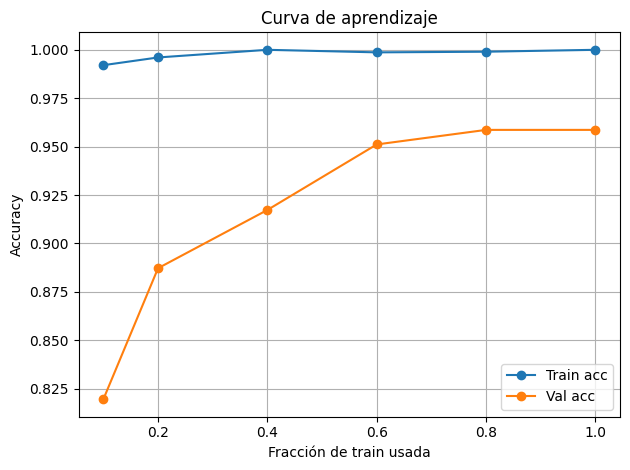

In [20]:
import numpy as np
import matplotlib.pyplot as plt

fracs = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
train_scores, val_scores = [], []

rng = np.random.RandomState(7)
for f in fracs:
    n = int(len(y_train) * f)
    idx = rng.permutation(len(y_train))[:n]
    X_tr, y_tr = X_train[idx], y_train[idx]

    m = NeuralNet(learning_rate=0.01, activation_function='ReLu',
                  layer_neurons=[32,16], epoch=200, batch_size=32)
    m.fit(X_tr, y_tr)

    map_m = {c:i for i,c in enumerate(m.classes)}
    y_tr_idx = np.array([map_m[l] for l in y_tr])
    y_va_idx = np.array([map_m[l] for l in y_val])

    train_scores.append((m.predict(X_tr) == y_tr_idx).mean())
    val_scores.append((m.predict((X_val_raw - mean_train)/std_train) == y_va_idx).mean())

plt.plot(fracs, train_scores, '-o', label='Train acc')
plt.plot(fracs, val_scores,  '-o', label='Val acc')
plt.xlabel('Fracción de train usada'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.title('Curva de aprendizaje'); plt.tight_layout(); plt.show()

In [14]:
# Cross-validation para evaluar robustez sobre el conjunto de entrenamiento
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
accs = []

for tr_idx, va_idx in kf.split(X_train_raw, y_train):
    X_tr, X_va = X_train_raw[tr_idx], X_train_raw[va_idx]
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]

    # Escalado por fold usando solo el train
    mean_tr = X_tr.mean(axis=0)
    std_tr = X_tr.std(axis=0)
    std_tr = np.where((~np.isfinite(std_tr)) | (std_tr == 0), 1.0, std_tr)
    X_tr_s = (X_tr - mean_tr) / std_tr
    X_va_s = (X_va - mean_tr) / std_tr

    model_cv = NeuralNet(
        learning_rate=0.01,
        activation_function='ReLu',
        layer_neurons=[32, 16],
        epoch=200,
        batch_size=32
    )
    model_cv.fit(X_tr_s, y_tr)
    y_pred_idx = model_cv.predict(X_va_s)
    y_pred = np.array(model_cv.classes)[y_pred_idx]
    accs.append((y_pred == y_va).mean())

print(f"CV Accuracy (5 folds): mean={np.mean(accs):.3f} ± {np.std(accs):.3f}")


Epoch   1 | loss=2.7548 | acc=0.133
Epoch  10 | loss=1.1850 | acc=0.746
Epoch  10 | loss=1.1850 | acc=0.746
Epoch  20 | loss=0.4695 | acc=0.895
Epoch  20 | loss=0.4695 | acc=0.895
Epoch  30 | loss=0.2622 | acc=0.945
Epoch  40 | loss=0.1761 | acc=0.958
Epoch  30 | loss=0.2622 | acc=0.945
Epoch  40 | loss=0.1761 | acc=0.958
Epoch  50 | loss=0.1298 | acc=0.972
Epoch  60 | loss=0.0991 | acc=0.982
Epoch  50 | loss=0.1298 | acc=0.972
Epoch  60 | loss=0.0991 | acc=0.982
Epoch  70 | loss=0.0781 | acc=0.989
Epoch  70 | loss=0.0781 | acc=0.989
Epoch  80 | loss=0.0639 | acc=0.993
Epoch  80 | loss=0.0639 | acc=0.993
Epoch  90 | loss=0.0534 | acc=0.994
Epoch  90 | loss=0.0534 | acc=0.994
Epoch 100 | loss=0.0451 | acc=0.995
Epoch 100 | loss=0.0451 | acc=0.995
Epoch 110 | loss=0.0386 | acc=0.997
Epoch 110 | loss=0.0386 | acc=0.997
Epoch 120 | loss=0.0332 | acc=0.998
Epoch 120 | loss=0.0332 | acc=0.998
Epoch 130 | loss=0.0291 | acc=0.998
Epoch 140 | loss=0.0261 | acc=0.998
Epoch 130 | loss=0.0291 | ac

In [ ]:
#graficar los resultados
